In [1]:
import numpy as np
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# Find best filters using evolutionary algorithm

## Calculations

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
train_images = mnist_train.data.float() / 255.0 

#
population_size = 20
filter_size = 7
num_filters = 5
generations = 50
mutation_rate = 0.1

def initialize_population(pop_size, num_filters, filter_size):
    if pop_size < 2:
        raise ValueError("Population size must be at least 2.")
    return [np.random.uniform(-1, 1, (num_filters, filter_size, filter_size)) for _ in range(pop_size)]

def compute_fitness(filters, images):
    responses = []
    for filter_set in filters:
        response = 0
        for f in filter_set:
            conv_result = torch.nn.functional.conv2d(
                images.unsqueeze(1), 
                torch.tensor(f, dtype=torch.float32).unsqueeze(0).unsqueeze(0), 
                padding=filter_size // 2
            )
            response += torch.abs(conv_result).mean().item()
        responses.append(response)
    return responses

def select_parents(population, fitness):
    selected = []
    if len(population) < 2:
        print("Population size is less than 2. Ending simulation.")
        return []  
    for _ in range(len(population)):
        i, j = np.random.choice(len(population), 2, replace=False)
        selected.append(population[i] if fitness[i] > fitness[j] else population[j])
    return selected

def crossover(parent1, parent2):
    child = []
    for f1, f2 in zip(parent1, parent2):
        alpha = np.random.uniform(0, 1)
        child.append(alpha * f1 + (1 - alpha) * f2)
    return np.array(child)

def mutate(filters, mutation_rate):
    for f in filters:
        if np.random.rand() < mutation_rate:
            f += np.random.normal(0, 0.1, f.shape)
    return filters


def evolve(images, pop_size, num_filters, filter_size, generations, mutation_rate):
    population = initialize_population(pop_size, num_filters, filter_size)
    best_filters = None
    best_fitness = float('-inf')  

    for generation in range(generations):
        fitness = compute_fitness(population, images)

        
        if not fitness:
            print(f"Generation {generation + 1}: Fitness list is empty. Ending simulation.")
            return best_filters  

        current_best_fitness = max(fitness)
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_filters = population[np.argmax(fitness)]

        print(f"Generation {generation + 1}, Best Fitness: {current_best_fitness:.4f}")
        parents = select_parents(population, fitness)

        if len(parents) % 2 != 0:
            parents.append(parents[-1])  

        offspring = [crossover(parents[i], parents[i + 1]) for i in range(0, len(parents), 2)]
        population = [mutate(child, mutation_rate) for child in offspring]

    return best_filters

best_filters = evolve(train_images, population_size, num_filters, filter_size, generations, mutation_rate)


Generation 1, Best Fitness: 4.6076
Generation 2, Best Fitness: 3.3855
Generation 3, Best Fitness: 3.1137
Generation 4, Best Fitness: 3.1017
Generation 5, Best Fitness: 3.1017
Generation 6, Best Fitness: 3.1017
Population size is less than 2. Ending simulation.
Generation 7: Fitness list is empty. Ending simulation.


## Results

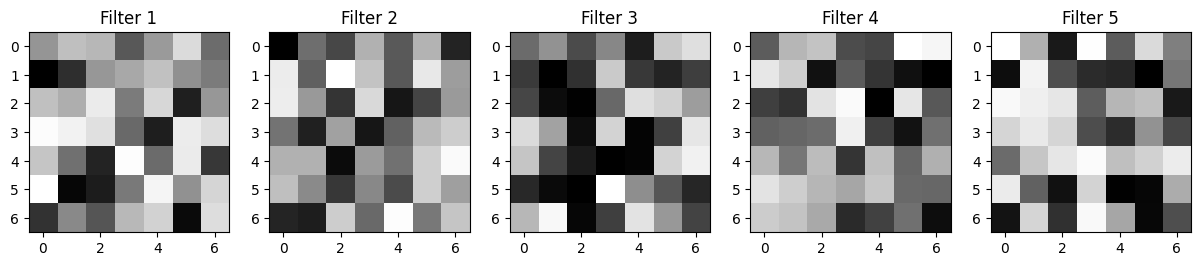

In [4]:
plt.figure(figsize=(15, 5))
for i, f in enumerate(best_filters):
    plt.subplot(1, num_filters, i + 1)
    plt.imshow(f, cmap='gray')
    plt.title(f"Filter {i + 1}")
plt.show()

In [5]:
best_filters.shape

(5, 7, 7)

In [6]:
best_filters = best_filters.reshape(5, 7, 1, 7)
best_filters.shape

(5, 7, 1, 7)

# Test the best filters

## Setup

In [8]:
# load the MINST dataset via torchvision
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))])
#Using default values (like 0.5/0.5) might work "okay," but It doesn’t provide an optimal data distribution
mnist_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
# we divide this data into training and validation subsets
train_subset, validation_subset = torch.utils.data.random_split(mnist_train, [50000, 10000])
#test data separately – these are 10000 images the model has never seen before.
test_subset = datasets.MNIST('../data', train=False, download=True, transform=transform)

# define dataloaders - objects responsible for loading data during model training.
loader_kwargs = {'batch_size': 128,
                 'num_workers': 2,
                 'pin_memory': True,
                 'shuffle': True} #randomly shuffles the data in each epoch – this prevents the model from memorizing the order and improves generalization.
#We create 3 separate DataLoaders – one for each data subset:
train_loader = torch.utils.data.DataLoader(train_subset, **loader_kwargs)
validation_loader = torch.utils.data.DataLoader(validation_subset, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_subset, **loader_kwargs)

In [9]:
#And define training, testing, and plotting utils:
def train(model, device, train_loader, optimizer, epoch_number):
    model.train()
    train_loss = 0.
    # get subsequent batches over the data in a given epoch
    for batch_idx, (data, target) in enumerate(train_loader):
        # send data tensors to GPU (or CPU)
        data, target = data.to(device), target.to(device)
        # this will zero out the gradients for this batch
        optimizer.zero_grad()
        # this will execute the forward() function
        output = model(data)
        # calculate the negative-log-likelihood loss
        loss = F.nll_loss(output, target, reduction='mean')
        # backpropagate the loss
        loss.backward()
        # update the model weights (with assumed learning rate)
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch_number, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        train_loss += loss.item()
    train_loss /= len(train_loader)
    print('\nTrain set: Average loss: {:.4f}'.format(train_loss))
    return train_loss

def test(model, device, test_loader, message):
    model.eval()
    test_loss = 0.
    correct = 0
    # this is just inference, we don't need to calculate gradients
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # calculate and sum up batch loss
            test_loss += F.nll_loss(output, target, reduction='mean')
            # get the index of class with the max log-probability
            prediction = output.argmax(dim=1)
            # item() returns value of the given tensor
            correct += prediction.eq(target).sum().item()
    test_loss /= len(test_loader)
    print('{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        message, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss.cpu()

def plot_loss(train_loss, validation_loss, title):
    plt.grid(True)
    plt.xlabel("subsequent epochs")
    plt.ylabel('average loss')
    plt.plot(range(1, len(train_loss)+1), train_loss, 'o-', label='training')
    plt.plot(range(1, len(validation_loss)+1), validation_loss, 'o-', label='validation')
    plt.legend()
    plt.title(title)
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Net(nn.Module):
    def __init__(self, kernel: torch.Tensor):
        super().__init__()
        self.conv = nn.Conv2d(1, kernel.size(0), kernel.size(2),
                              padding=kernel.size(2)//2, bias=False)
        self.conv.weight.data = kernel
        self.conv.weight.requires_grad_(False) # Freeze the weights on filters
        self.pool = nn.MaxPool2d(2,2)
        # run a dummy through to get the flattened size
        with torch.no_grad():
            dummy = torch.zeros(1,1,28,28)
            out = self.pool(torch.relu(self.conv(dummy)))
            n_feats = out.view(1,-1).size(1)
        self.fc1 = nn.Linear(n_feats, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## Applay the best filters

In [ ]:
# load filters from the previous step
kernel = torch.from_numpy(best_filters).permute(3,2,0,1).float()
model = Net(kernel).to(device)

c:\Users\Ignacy\Desktop\programowanie\Studia\sem6\AI_1\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Epoch: 1 [0/50000 (0%)]	Loss: 3.213757
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.581196
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.336958
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.470520

Train set: Average loss: 0.4503
Val: Average loss: 0.1734, Accuracy: 9472/10000 (95%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.227794
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.370211
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.120586
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.374276

Train set: Average loss: 0.2619
Val: Average loss: 0.1418, Accuracy: 9590/10000 (96%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 0.356195
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.272311
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.305803
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.205211

Train set: Average loss: 0.2231
Val: Average loss: 0.1208, Accuracy: 9620/10000 (96%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.130719
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.124145
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.205220
Train 

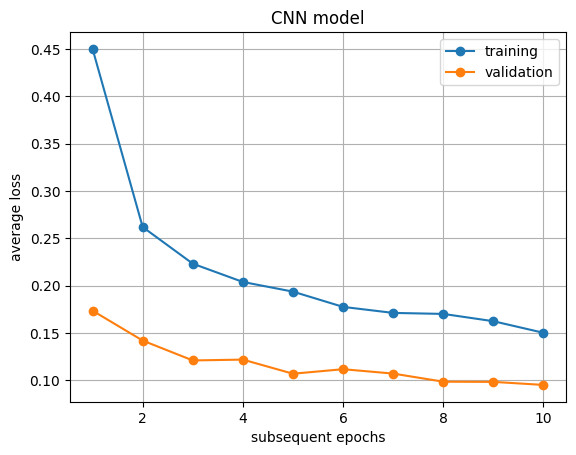

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
train_loss = []
validation_loss = []

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

for epoch in range(1, 10+1):
    train_loss.append(train(model, device, train_loader, optimizer, epoch))
    validation_loss.append(test(model, device, validation_loader, 'Val'))
    scheduler.step()

test(model, device, test_loader, 'Test set')
plot_loss(train_loss, validation_loss, 'CNN model')

Final result is accuracy of 97.4%